<a href="https://colab.research.google.com/github/ssarker21/Introduction-to-Machine-Learning/blob/main/Homework6_Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch    1, Train loss 0.7044, Val loss 0.7046
Epoch    2, Train loss 0.7036, Val loss 0.7039
Epoch    3, Train loss 0.7028, Val loss 0.7031
Epoch   50, Train loss 0.6702, Val loss 0.6721
Epoch  100, Train loss 0.6427, Val loss 0.6464
Epoch  150, Train loss 0.6195, Val loss 0.6255
Epoch  200, Train loss 0.5991, Val loss 0.6079


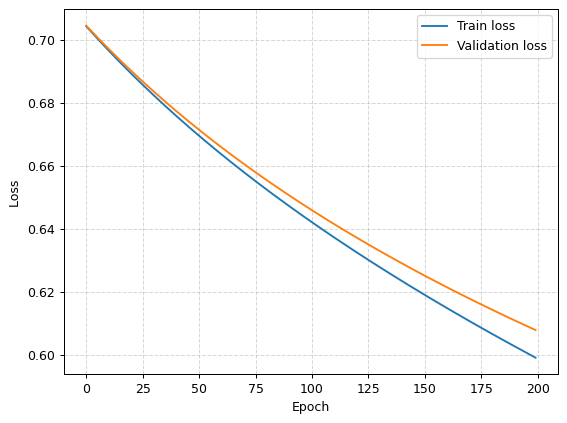

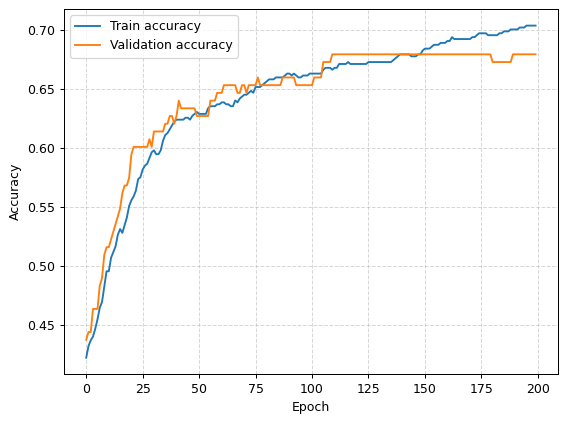


=== Evaluation on Validation Set ===
Accuracy : 0.6732
Precision: 0.5217
Recall   : 0.2353
F1 score : 0.3243


In [35]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt

# ------------------------------------
# 0) Load diabetes dataset
# ------------------------------------
url = "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/diabetes.csv"
df = pd.read_csv(url)

# Assume last column is the label (0/1), others are features
cols_X = df.columns[:-1]
col_y  = df.columns[-1]

X_full = torch.tensor(df[cols_X].values, dtype=torch.float32)
y_full = torch.tensor(df[col_y].values,  dtype=torch.float32).unsqueeze(1)  # (N,1)

# ------------------------------------
# 1) Train / Validation split (80 / 20)
# ------------------------------------
n_samples = X_full.shape[0]
n_val = int(0.2 * n_samples)

indices = torch.randperm(n_samples)
train_idx = indices[:-n_val]
val_idx   = indices[-n_val:]

X_train = X_full[train_idx]
y_train = y_full[train_idx]
X_val   = X_full[val_idx]
y_val   = y_full[val_idx]

# ------------------------------------
# 2) Pre-processing: standardize inputs (z-score)
#    (Use only TRAIN mean/std, then apply to both)
# ------------------------------------
x_mean = X_train.mean(dim=0, keepdim=True)
x_std  = X_train.std(dim=0, keepdim=True) + 1e-8

X_train_std = (X_train - x_mean) / x_std
X_val_std   = (X_val   - x_mean) / x_std

# ------------------------------------
# 3) Fully-connected neural network
#    (multiple hidden layers, simple nn.Sequential)
# ------------------------------------
n_features = X_train_std.shape[1]

seq_model = nn.Sequential(
    nn.Linear(n_features, 16),  # hidden layer 1
    nn.Tanh(),
    nn.Linear(16, 8),           # hidden layer 2
    nn.Tanh(),
    nn.Linear(8, 1)             # output layer (1 logit for binary classification)
)

# ------------------------------------
# 4) Loss and optimizer
# ------------------------------------
# For 0/1 labels we use BCEWithLogitsLoss (works directly on raw output)
loss_fn   = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(seq_model.parameters(), lr=1e-2)

# ------------------------------------
# 5) Training loop (like in the slides)
#    -> now also records accuracy
# ------------------------------------
def training_loop(n_epochs, optimizer, model, loss_fn,
                  X_train, X_val, y_train, y_val):
    train_losses = []
    val_losses   = []
    train_accs   = []
    val_accs     = []

    for epoch in range(1, n_epochs + 1):
        # ----- forward on training data -----
        y_pred_train = model(X_train)
        train_loss   = loss_fn(y_pred_train, y_train)

        # ----- forward on validation data (no backward) -----
        with torch.no_grad():
            y_pred_val = model(X_val)
            val_loss   = loss_fn(y_pred_val, y_val)

        # ----- backward + update using ONLY training loss -----
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # ----- compute accuracies (after forward, before next epoch) -----
        with torch.no_grad():
            # sigmoid -> probabilities, threshold at 0.5
            train_preds = (torch.sigmoid(y_pred_train) >= 0.5).float()
            val_preds   = (torch.sigmoid(y_pred_val)   >= 0.5).float()

            train_acc = (train_preds == y_train).float().mean()
            val_acc   = (val_preds   == y_val).float().mean()

        train_losses.append(float(train_loss.detach()))
        val_losses.append(float(val_loss.detach()))
        train_accs.append(float(train_acc))
        val_accs.append(float(val_acc))

        if epoch <= 3 or epoch % 50 == 0:
            print(
                f"Epoch {epoch:4d}, "
                f"Train loss {train_loss.item():.4f}, "
                f"Val loss {val_loss.item():.4f}"
            )

    return train_losses, val_losses, train_accs, val_accs

# ------------------------------------
# 6) Run training (e.g., 200 epochs)
# ------------------------------------
n_epochs = 200
train_hist, val_hist, train_acc_hist, val_acc_hist = training_loop(
    n_epochs    = n_epochs,
    optimizer   = optimizer,
    model       = seq_model,
    loss_fn     = loss_fn,
    X_train     = X_train_std,
    X_val       = X_val_std,
    y_train     = y_train,
    y_val       = y_val
)

# ------------------------------------
# 7) Plot training vs validation loss
# ------------------------------------
fig = plt.figure(dpi=90)
plt.xlabel("Epoch")
plt.ylabel("Loss ")
plt.plot(train_hist, label="Train loss")
plt.plot(val_hist,   label="Validation loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ------------------------------------
# 8) Plot training vs validation accuracy
# ------------------------------------
fig = plt.figure(dpi=90)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(train_acc_hist, label="Train accuracy")
plt.plot(val_acc_hist,   label="Validation accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ------------------------------------
# 9) Final metrics: Accuracy, Precision, Recall, F1 (Validation set)
# ------------------------------------
with torch.no_grad():
    logits_val = seq_model(X_val_std)
    probs_val  = torch.sigmoid(logits_val)
    preds_val  = (probs_val >= 0.5).float()   # predicted labels (0/1)

# Flatten to 1D for easier counting
y_true = y_val.view(-1)
y_pred = preds_val.view(-1)

# Compute confusion matrix elements
tp = ((y_pred == 1) & (y_true == 1)).sum().item()
tn = ((y_pred == 0) & (y_true == 0)).sum().item()
fp = ((y_pred == 1) & (y_true == 0)).sum().item()
fn = ((y_pred == 0) & (y_true == 1)).sum().item()

# Avoid division by zero using small epsilon
eps = 1e-8

accuracy  = (tp + tn) / (tp + tn + fp + fn + eps)
precision = tp / (tp + fp + eps)
recall    = tp / (tp + fn + eps)
f1        = 2 * precision * recall / (precision + recall + eps)

print("\n=== Evaluation on Validation Set ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 score : {f1:.4f}")


In [42]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ------------------------------------
# 0) Load diabetes dataset
# ------------------------------------
url = "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/main/Dataset/diabetes.csv"
df = pd.read_csv(url)

# Assume last column is the label (0/1), others are features
cols_X = df.columns[:-1]
col_y  = df.columns[-1]

X = df[cols_X].values.astype(np.float32)
y = df[col_y].values.astype(np.int64)

# ------------------------------------
# 1) Train / Validation split (80 / 20)
# ------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
    stratify=y
)

# ------------------------------------
# 2) Standardize features using TRAIN stats
# ------------------------------------
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std   = scaler.transform(X_val)

# ------------------------------------
# Helper to compute metrics
# ------------------------------------
def compute_metrics(name, y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n=== {name} (Validation set) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 score : {f1:.4f}")

# ------------------------------------
# 3) Logistic Regression
# ------------------------------------
log_reg = LogisticRegression(
    penalty="l2",
    C=4.0,
    solver="lbfgs",
    max_iter=1000
)
log_reg.fit(X_train_std, y_train)
y_val_pred_log = log_reg.predict(X_val_std)
compute_metrics("Logistic Regression", y_val, y_val_pred_log)

# ------------------------------------
# 4) Support Vector Machine (SVM, RBF kernel)
# ------------------------------------
svm_clf = SVC(
    kernel="rbf",
    C=4.0,
    gamma="scale"
)
svm_clf.fit(X_train_std, y_train)
y_val_pred_svm = svm_clf.predict(X_val_std)
compute_metrics("SVM (RBF kernel)", y_val, y_val_pred_svm)



=== Logistic Regression (Validation set) ===
Accuracy : 0.7792
Precision: 0.7381
Recall   : 0.5741
F1 score : 0.6458

=== SVM (RBF kernel) (Validation set) ===
Accuracy : 0.7922
Precision: 0.7619
Recall   : 0.5926
F1 score : 0.6667
